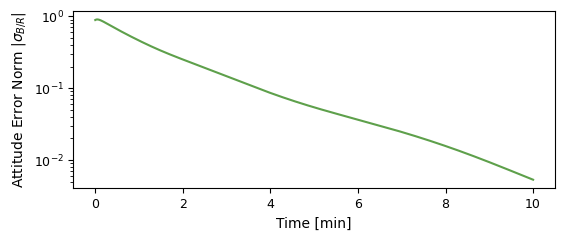

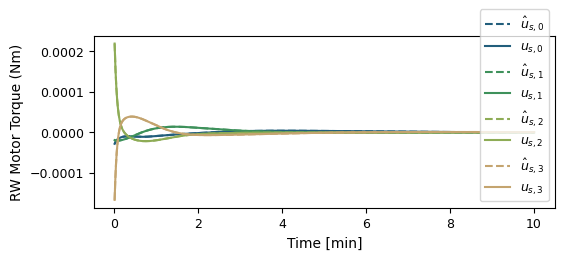

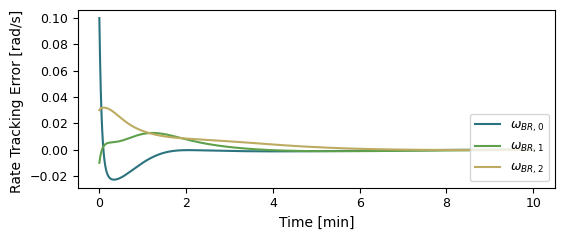

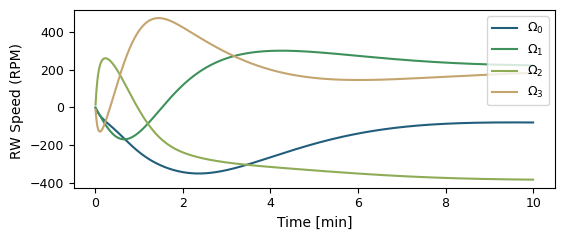

In [1]:

# Get current file path
import inspect
import os
import sys

import numpy as np
# Import utilities
from Basilisk.utilities import orbitalMotion, macros, vizSupport

filename = inspect.getframeinfo(inspect.currentframe()).filename
path = os.getcwd()

# Import master classes: simulation base class and scenario base class
sys.path.append(path + '/../')
sys.path.append(path + '/../models')
sys.path.append(path + '/../plotting')
from sim_masters import Sim, Scenario
import cubesat_dynamics, cubesat_fsw
import cubesat_plotting as plots


# Create your own scenario child class
class scenario_AttitudeFeedbackRW(Sim, Scenario):
    def __init__(self):
        super(scenario_AttitudeFeedbackRW, self).__init__()
        self.name = 'scenario_AttitudeFeedbackRW'

        # declare additional class variables
        self.rwSpeedRec = None
        self.rwMotorRec = None
        self.attErrRec = None
        self.rwLogs = []

        self.set_DynModel(cubesat_dynamics)
        self.set_FswModel(cubesat_fsw)

        self.configure_initial_conditions()
        self.log_outputs()

    def configure_initial_conditions(self):
        # Configure Dynamics initial conditions
        oe = orbitalMotion.ClassicElements()
        oe.a = 10000000.0  # meters
        oe.e = 0.01
        oe.i = 33.3 * macros.D2R
        oe.Omega = 48.2 * macros.D2R
        oe.omega = 347.8 * macros.D2R
        oe.f = 85.3 * macros.D2R

        DynModels = self.get_DynModel()
        mu = DynModels.gravFactory.gravBodies['earth'].mu
        rN, vN = orbitalMotion.elem2rv(mu, oe)
        orbitalMotion.rv2elem(mu, rN, vN)
        DynModels.scObject.hub.r_CN_NInit = rN  # m   - r_CN_N
        DynModels.scObject.hub.v_CN_NInit = vN  # m/s - v_CN_N
        DynModels.scObject.hub.sigma_BNInit = [[0.1], [0.2], [-0.3]]  # sigma_BN_B
        DynModels.scObject.hub.omega_BN_BInit = [[0.1], [-0.01], [0.03]]  # rad/s - omega_BN_B

    def log_outputs(self):
        FswModel = self.get_FswModel()
        DynModel = self.get_DynModel()
        samplingTime = FswModel.processTasksTimeStep
        self.rwSpeedRec = DynModel.rwStateEffector.rwSpeedOutMsg.recorder(samplingTime)
        self.rwMotorRec = FswModel.cmdRwMotorMsg.recorder(samplingTime)
        self.attErrRec = FswModel.attGuidMsg.recorder(samplingTime)

        self.AddModelToTask(DynModel.taskName, self.rwSpeedRec)
        self.AddModelToTask(DynModel.taskName, self.rwMotorRec)
        self.AddModelToTask(DynModel.taskName, self.attErrRec)

        self.rwLogs = []
        for item in range(4):
            self.rwLogs.append(DynModel.rwStateEffector.rwOutMsgs[item].recorder(samplingTime))
            self.AddModelToTask(DynModel.taskName, self.rwLogs[item])

        return

    def pull_outputs(self, showPlots):
        num_RW = 4  # number of wheels used in the scenario

        # FSW process outputs, remove first data point as it is before FSW is called
        dataUsReq = np.delete(self.rwMotorRec.motorTorque[:, range(num_RW)], 0, 0)
        sigma_BR = np.delete(self.attErrRec.sigma_BR, 0, 0)
        omega_BR_B = np.delete(self.attErrRec.omega_BR_B, 0, 0)
        RW_speeds = np.delete(self.rwSpeedRec.wheelSpeeds[:, range(num_RW)], 0, 0)
        dataRW = []
        for i in range(num_RW):
            dataRW.append(np.delete(self.rwLogs[i].u_current, 0, 0))

        # Plot results
        plots.clear_all_plots()
        timeData = np.delete(self.rwMotorRec.times(), 0, 0) * macros.NANO2MIN
        plots.plot_attitude_error(timeData, sigma_BR)
        plots.plot_rw_cmd_actual_torque(timeData, dataUsReq, dataRW, num_RW)
        plots.plot_rate_error(timeData, omega_BR_B)
        plots.plot_rw_speeds(timeData, RW_speeds, num_RW)
        figureList = {}
        if showPlots:
            plots.show_all_plots()
        else:
            fileName = os.path.basename(os.path.splitext(__file__)[0])
            figureNames = ["attitudeErrorNorm", "rwMotorTorque", "rateError", "rwSpeed"]
            figureList = plots.save_all_plots(fileName, figureNames)

        return figureList


def runScenario(scenario):
    # Initialize simulation
    scenario.InitializeSimulation()

    # Configure run time and execute simulation
    simulationTime = macros.min2nano(10.)
    scenario.modeRequest = 'inertial3D'
    scenario.ConfigureStopTime(simulationTime)
    scenario.ExecuteSimulation()


def run(showPlots):
    TheScenario = scenario_AttitudeFeedbackRW()
    runScenario(TheScenario)
    figureList = TheScenario.pull_outputs(showPlots)

    return figureList


if __name__ == "__main__":
    run(True)
